### Train the Logistic Regression in PyTorch
Ref: https://lightning.ai/courses/deep-learning-fundamentals/3-0-overview-model-training-in-pytorch/3-6-training-a-logistic-regression-model-in-pytorch-parts-1-3/

In [101]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import tensor
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

#### Load & Preprocess dataset

In [102]:
train_df = pd.read_csv('dataset/perception_toydata-truncated.csv')
train_df['label'].value_counts()

0    10
1    10
Name: label, dtype: int64

In [103]:
X_train = train_df[['x1', 'x2']].values
y_train = train_df['label'].values

In [104]:
X_train = (X_train - X_train.mean()) / X_train.std()
X_train

array([[ 0.10563776, -0.89074802],
       [-0.46819698,  0.45515528],
       [ 0.17867127, -1.89756715],
       [-0.4890637 , -1.29243234],
       [-0.62469737, -1.09419852],
       [-0.09259606, -1.33416577],
       [-0.55166385, -1.72541673],
       [-0.65078076, -1.08898184],
       [-0.34821335, -2.08536761],
       [-0.32212996, -1.31329905],
       [ 1.72802507,  0.04303761],
       [ 0.08477104,  1.25330724],
       [ 0.13693784,  1.75932515],
       [ 0.53340547,  0.35603837],
       [ 0.2986549 ,  1.74367511],
       [ 0.60643899,  1.16462369],
       [ 0.38733845,  0.66903914],
       [ 0.51775544,  1.71237503],
       [ 0.34560501,  1.02899002],
       [ 0.39777181,  0.76293937]])

#### Plot dataset

In [105]:
def plot_examples(X_train, y_train):
    plt.figure(figsize=(5,4))
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.scatter(X_train[y_train==0,0], X_train[y_train==0,1], marker='o', label='class 0')
    plt.scatter(X_train[y_train==1,0], X_train[y_train==1,1], marker='^', label='class 1')
    plt.legend()
    plt.grid()
    plt.show()

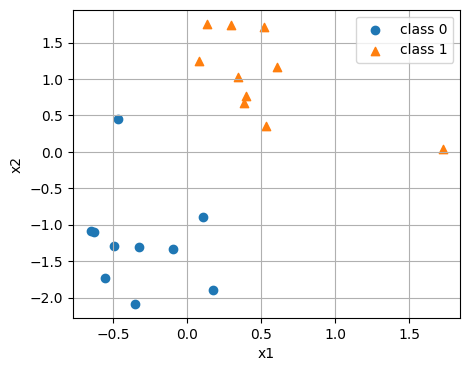

In [106]:
plot_examples(X_train, y_train)

#### Define dataset loader

In [107]:
class MyDataset(Dataset):
    def __init__(self, X, y):
        self.features = tensor(X, dtype=torch.float32)
        self.labels = tensor(y, dtype=torch.float32)

    def __getitem__(self, index):
        x = self.features[index]
        y = self.labels[index]
        return x, y
    
    def __len__(self):
        return self.labels.shape[0]

# train_ds = MyDataset(X_train, y_batch)
# train_loader = DataLoader(dataset=train_ds, batch_size=10, shuffle=True)

#### Define the Model

In [108]:
class LogisticRegression(torch.nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.linear = torch.nn.Linear(input_size, 1)

    def forward(self, x):
        logits = self.linear(x) # weighted sum
        prob = torch.sigmoid(logits)
        return prob

In [109]:
model = LogisticRegression(2)
# model.parameters

#### Training

In [110]:
def train(model: torch.nn.Module, dataset: Dataset, epochs, batch_size, learning_rate):
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    dataset_loader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True)
    
    for epoch in range(epochs):
        forward = model.train() # set the model to the training mode ?
        
        # loop over every batch of the dataset
        for batch_idx, (x_batch, y_batch) in enumerate(dataset_loader):
            probs = forward(x_batch) # compute probabilities for this batch
            loss = F.binary_cross_entropy(probs, y_batch.view(probs.shape)) # compute the loss for this batch
            
            optimizer.zero_grad() # zero out the gradients, why?
            loss.backward() # backpropagation
            optimizer.step() # update weights

        print(f'Epoch: {epoch+1:02d}/{epochs:02d} - Loss: {loss}')

In [111]:
learning_rate = 0.05
batch_size = 10
epochs = 50

dataset = MyDataset(X_train, y_train)

model = LogisticRegression(2)
train(model, dataset, epochs, batch_size, learning_rate)

Epoch: 01/50 - Loss: 1.176053762435913
Epoch: 02/50 - Loss: 1.1442654132843018
Epoch: 03/50 - Loss: 0.9600909352302551
Epoch: 04/50 - Loss: 0.9368861317634583
Epoch: 05/50 - Loss: 0.7825780510902405
Epoch: 06/50 - Loss: 0.7858968377113342
Epoch: 07/50 - Loss: 0.8125349879264832
Epoch: 08/50 - Loss: 0.8066583871841431
Epoch: 09/50 - Loss: 0.7326322793960571
Epoch: 10/50 - Loss: 0.6218246817588806
Epoch: 11/50 - Loss: 0.6559210419654846
Epoch: 12/50 - Loss: 0.5816117525100708
Epoch: 13/50 - Loss: 0.6078930497169495
Epoch: 14/50 - Loss: 0.5493596196174622
Epoch: 15/50 - Loss: 0.4940210282802582
Epoch: 16/50 - Loss: 0.46813687682151794
Epoch: 17/50 - Loss: 0.4350601136684418
Epoch: 18/50 - Loss: 0.44438013434410095
Epoch: 19/50 - Loss: 0.4173574447631836
Epoch: 20/50 - Loss: 0.4430277347564697
Epoch: 21/50 - Loss: 0.42864322662353516
Epoch: 22/50 - Loss: 0.396250456571579
Epoch: 23/50 - Loss: 0.41173791885375977
Epoch: 24/50 - Loss: 0.31682687997817993
Epoch: 25/50 - Loss: 0.32434728741645

#### Evaluation

In [112]:
def compute_accuracy(model: torch.nn.Module, dataset: Dataset, threshold):
    model = model.eval() # set the model to the evaluation mode

    true_predictions = 0
    total_examples = 0

    for idx, (x_batch, y_batch) in enumerate(dataset):
        with torch.no_grad(): # ?
            probs = model(x_batch)
        
        predictions = torch.where(probs > threshold, 1, 0)
        labels = y_batch.view(predictions.shape).to(predictions.dtype)

        compare = predictions == labels
        true_predictions += torch.sum(compare)
        total_examples += len(compare)

    return true_predictions / total_examples

In [113]:
threshold = 0.5
acc = compute_accuracy(model, dataset, threshold)
print(f'Accuracy = {acc*100}%')

Accuracy = 95.0%


#### Visualize decision boundary

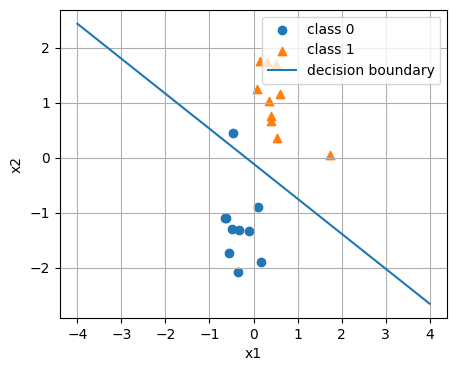

In [114]:
def plot_decision_boundary(model, X_train, y_train):
    plt.figure(figsize=(5,4))
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.grid()
    
    plt.scatter(X_train[y_train==0,0], X_train[y_train==0,1], marker='o', label='class 0')
    plt.scatter(X_train[y_train==1,0], X_train[y_train==1,1], marker='^', label='class 1')
    
    w1 = model.linear.weight[0][0].detach()
    w2 = model.linear.weight[0][1].detach()
    b = model.linear.bias[0].detach()

    x1_min = -4
    x2_min = -(b + w1*x1_min) / w2
    x1_max = 4
    x2_max = -(b + w1*x1_max) / w2
    plt.plot([x1_min, x1_max], [x2_min, x2_max], label='decision boundary')

    plt.legend()
    plt.show()

plot_decision_boundary(model, X_train, y_train)